In [12]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Connect to Google Drive to access the dataset
from google.colab import drive
drive.mount('/content/drive')

# Load the dataset
path = '/content/drive/My Drive/Datasets/IBM_HR_Attrition.csv'
data = pd.read_csv(path)
print(data.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
   Age Attrition     BusinessTravel  DailyRate              Department  \
0   41       Yes      Travel_Rarely       1102                   Sales   
1   49        No  Travel_Frequently        279  Research & Development   
2   37       Yes      Travel_Rarely       1373  Research & Development   
3   33        No  Travel_Frequently       1392  Research & Development   
4   27        No      Travel_Rarely        591  Research & Development   

   DistanceFromHome  Education EducationField  EmployeeCount  EmployeeNumber  \
0                 1          2  Life Sciences              1               1   
1                 8          1  Life Sciences              1               2   
2                 2          2          Other              1               4   
3                 3          4  Life Sciences              1               5   
4                 2       

In [13]:
# Data Cleaning
# Check for missing values and duplicates
print("Missing values in each column:\n", data.isnull().sum())

Missing values in each column:
 Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeNumber              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInC

In [14]:
data.drop_duplicates(inplace=True)

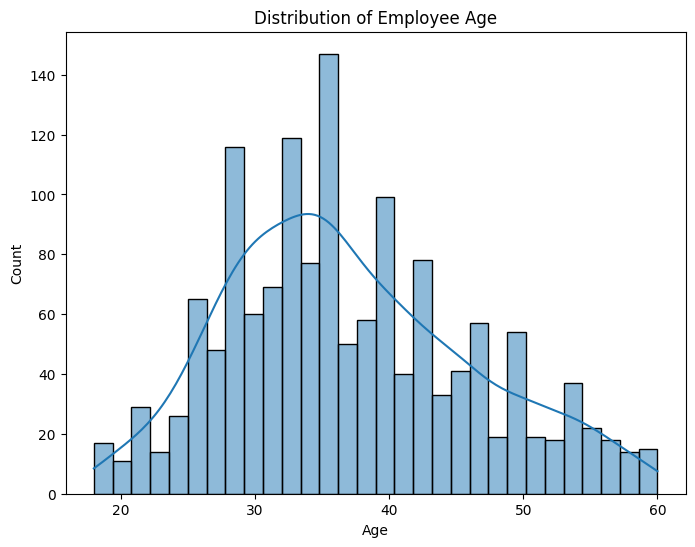

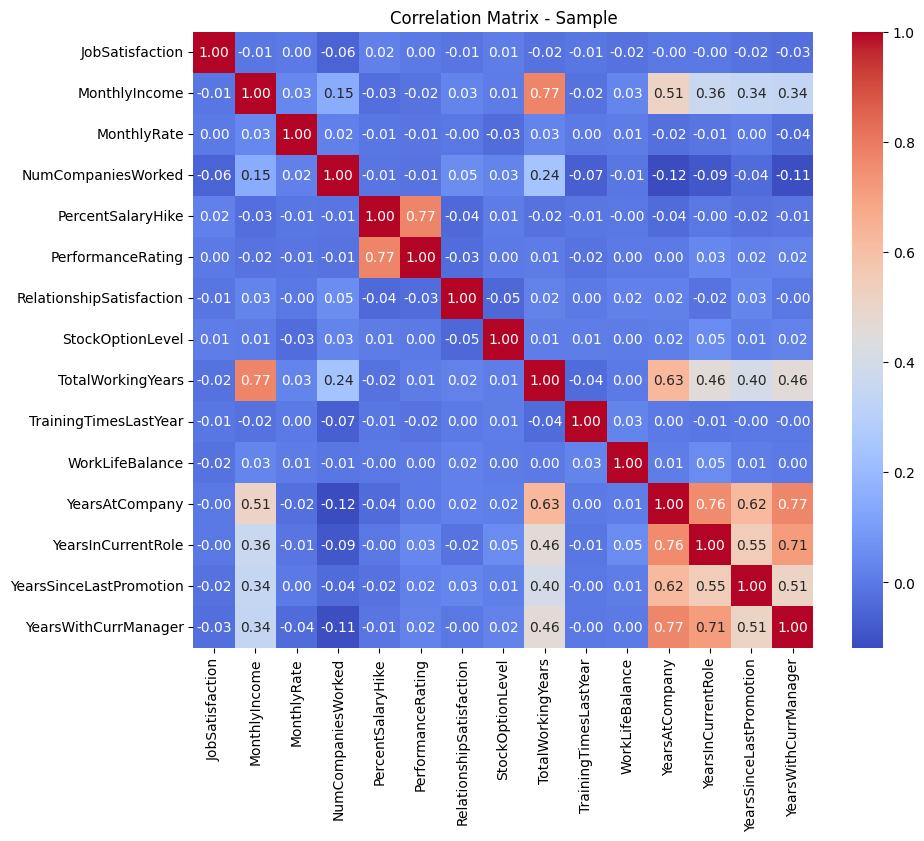

In [15]:
# Exploratory Data Analysis (EDA)
# Visualizing the distribution of employee ages
plt.figure(figsize=(8, 6))
sns.histplot(data['Age'], bins=30, kde=True)
plt.title('Distribution of Employee Age')
plt.show()

# Convert all categorical variables to numeric using one-hot encoding
categorical_cols = data.select_dtypes(include=['object']).columns  # Selecting columns that are 'object' type
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)
data.drop('StandardHours',inplace=True,axis=1)
# Correlation matrix - Simplified to show fewer variables for readability
smaller_corr_matrix = data.corr().iloc[10:25, 10:25]
plt.figure(figsize=(10, 8))
sns.heatmap(smaller_corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix - Sample')
plt.show()

In [16]:
# Preparing data for modeling
X = data[['PercentSalaryHike','PerformanceRating','TotalWorkingYears','YearsAtCompany','YearsInCurrentRole','YearsSinceLastPromotion','YearsWithCurrManager']]
y = data['Attrition_Yes']

# Handling class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

In [17]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=42)

# Initialize RandomForest
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [18]:
# Predictions and Evaluations
predictions = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, predictions))
print("Precision:", precision_score(y_test, predictions))
print("Recall:", recall_score(y_test, predictions))
print("Confusion Matrix:\n", confusion_matrix(y_test, predictions))

Accuracy: 0.827027027027027
Precision: 0.8123393316195373
Recall: 0.8517520215633423
Confusion Matrix:
 [[296  73]
 [ 55 316]]


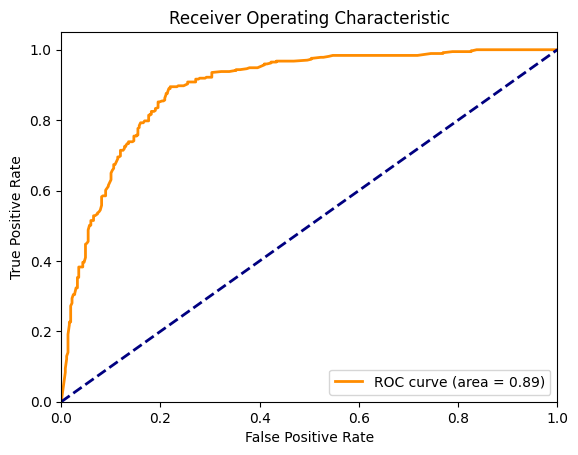

In [19]:
# ROC Curve and AUC
probabilities = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, probabilities)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [20]:
# Now Predicting with new employee data
new_employees = pd.DataFrame({
    'PercentSalaryHike': [7, 16, 11],
    'PerformanceRating': [2, 4, 3],
    'TotalWorkingYears': [2, 15, 12],
    'YearsAtCompany': [2, 7, 10],
    'YearsInCurrentRole': [4, 7, 8],
    'YearsSinceLastPromotion': [1, 2, 3],
    'YearsWithCurrManager': [1, 7, 8],
})

# One-hot encode the new employee data
new_employees_encoded = pd.get_dummies(new_employees)
# Add missing columns from the training set with default values of 0
missing_cols = set(X_train.columns) - set(new_employees_encoded.columns)
for c in missing_cols:
    new_employees_encoded[c] = 0
# Ensure the order of columns in the new data matches the training data
new_employees_encoded = new_employees_encoded[X_train.columns]

# Predict attrition using the trained model
new_predictions = model.predict(new_employees_encoded)
print("Predictions for new employees:")
print(new_predictions)  # Output will be 1 for 'True' (attrition) and 0 for 'False' (no attrition)

Predictions for new employees:
[ True False False]


So, There are chances of Employee 1 resigning from the job while employee 2 and 3 may not resign as per our prediction.